## Загрузим нужные библиотеки

In [1]:
# импорт библиотек
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     cross_val_predict)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (silhouette_score, roc_auc_score, confusion_matrix, classification_report, 
                             precision_recall_fscore_support, accuracy_score, precision_score, recall_score,
                             make_scorer, f1_score)
from catboost import CatBoost, CatBoostClassifier, Pool

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', None)

In [2]:
# загрузка датасетов
train = pd.read_csv("train_dataset_train.csv", parse_dates=True, infer_datetime_format=True)
test = pd.read_csv("test_dataset_test.csv", parse_dates=True, infer_datetime_format=True)

In [3]:
# просмотр размерности
train.shape, test.shape

((200000, 59), (84997, 58))

## Рассмотрим датасет по ближе

In [12]:
# первые 5 строк
train.head(5)

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,avg_hw_mark,test_with_good_mark,test_with_great_mark,webinars,avg_quiz_result,notes,hw_leader,lessons,activity,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,bought_avg_duration,payment_type,promo,price,communication_type,auto_payment,ABC,city,country,gender,speed_recall,os,browser,platform,m_avg_talk_duration,m_avg_duration,m_missed_calls,m_total_calls,m_was_conversations,m_total_duration,p_avg_talk_duration,p_avg_duration,p_missed_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
0,15182,32.0,9/30/2020,6694527,1469,8/26/2020,163.0,0.0,1.0,0.0,17.0,3.0,100.0,12.0,8.0,0.0,NaN,147.0,0.0,14.0,32.0,0,0,0,0,0,NaN,1,+,20043.0,phone,0,D,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,0
1,89385,NaN,6/30/2021,6712877,1392,8/5/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,15057.3,order,1,A,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,47931,NaN,2/28/2021,6659444,376,6/20/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,+,23389.0,web,0,D,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,279085,1.0,11/30/2021,7151591,1160,4/14/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,22260.6,order,1,B,NaN,NaN,1.0,NaN,Windows,Chrome,pc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,7806,30.0,10/31/2020,6705666,952,7/19/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,7255.5,order,1,A,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0


Замечено много пропущенных значений в данных. Необходимо посмотреть на состав всех полей и пропуски в данных.

In [13]:
# обзор состава колонок датасета
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 59 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         200000 non-null  int64  
 1   age_indicator              159123 non-null  float64
 2   month_id                   200000 non-null  object 
 3   student_id                 200000 non-null  int64  
 4   program_id                 200000 non-null  int64  
 5   carts_created_at           200000 non-null  object 
 6   spent_time_total           86309 non-null   float64
 7   spent_time_to_complete_hw  42467 non-null   float64
 8   completed_hw               97599 non-null   float64
 9   failed_hw                  97599 non-null   float64
 10  reworked_hw                97599 non-null   float64
 11  interacted_hw              97599 non-null   float64
 12  avg_hw_mark                44496 non-null   float64
 13  test_with_good_mark        97

In [9]:
# подсчёт пустых значений
train.isna().sum()

id                                0
age_indicator                 40877
month_id                          0
student_id                        0
program_id                        0
carts_created_at                  0
spent_time_total             113691
spent_time_to_complete_hw    157533
completed_hw                 102401
failed_hw                    102401
reworked_hw                  102401
interacted_hw                102401
avg_hw_mark                  155504
test_with_good_mark          102401
test_with_great_mark         102401
webinars                     102401
avg_quiz_result              183741
notes                        102401
hw_leader                    102401
lessons                      102401
activity                     102401
bought_d1                         0
bought_d2                         0
bought_d3                         0
bought_d4                         0
bought_d5                         0
bought_avg_duration          189641
payment_type                

В датасете много пропущенных значений. Потребуется обработать пропуски значений, в некоторых случаях указать нули, в других заполнить медианой. Так же считаю, что можно отбросить колонки с датами.

In [58]:
train.browser.value_counts()

Chrome                        30557
Mobile Safari                 12364
Chrome Mobile                  8239
Yandex Browser                 8204
Safari                         5128
Firefox                        2682
Opera                          2444
Edge                           1858
Instagram                      1630
Samsung Internet               1258
Chrome Mobile iOS              1010
MiuiBrowser                     615
Google                          373
Facebook                        298
Opera Mobile                    245
Chrome Mobile WebView           161
Firefox Mobile                  112
YandexSearch                     55
HeadlessChrome                   42
Mobile Safari UI/WKWebView       32
Firefox iOS                      22
Edge Mobile                      16
Chromium                         11
UC Browser                        7
Iron                              6
Android                           5
Name: browser, dtype: int64

In [51]:
train.os.value_counts()

Windows      36895
iOS          15665
Android      14096
Mac OS X     10097
Linux          439
Ubuntu         155
Fedora          14
Chrome OS       13
Name: os, dtype: int64

In [59]:
train.platform.value_counts()

pc        47600
mobile    29285
tablet      476
Name: platform, dtype: int64

In [86]:
train.communication_type.value_counts()

order    122191
web       49759
phone     28050
Name: communication_type, dtype: int64

In [52]:
train.country.value_counts()

Россия                   11727
Беларусь                   203
РФ                         202
Казахстан                  161
Украина                    157
Росссия                     52
Кыргызстан                  47
Кипр                        41
Латвия                      36
Германия                    28
Чешская Республика          20
Китай                       20
Франция                     19
Бельгия                     19
Испания                     17
Швейцария                   17
<span>Россия</span>         17
США                         15
Польша                      13
Люксембург                  13
Чили                        11
Великобритания              11
Израиль                     10
Латвия                       9
Канада                       9
Литва                        9
Турция                       8
Нидерланды                   8
Кыргызская Республика        7
Италия                       6
Япония                       6
Netherlands                  5
Республи

In [53]:
train.gender.value_counts()

0.0    87636
1.0    69315
2.0    42989
Name: gender, dtype: int64

In [55]:
train.city.value_counts()

Москва             5943
Санкт-Петербург    1698
Екатеринбург        272
Нижний Новгород     217
Новосибирск         195
                   ... 
Михайловск            1
Таганрог              1
Almere                1
Budva                 1
Москва/Сочи           1
Name: city, Length: 276, dtype: int64

In [60]:
train.payment_type.value_counts()

1    180431
2     19569
Name: payment_type, dtype: int64

In [61]:
train.communication_type.value_counts()

order    120786
web       49759
phone     28050
Name: communication_type, dtype: int64

In [63]:
train.ABC.value_counts()

D    100371
A     45884
B     42605
C     11140
Name: ABC, dtype: int64

In [54]:
train.target.value_counts()

0    174301
1     13512
5      3678
4      3659
3      3027
2      1823
Name: target, dtype: int64

Целевые категории плохо сбалансированны по соотношению друг к другу. Категории "0" и "1" по численности значительно больше чем остальные. 3, 4, 5 категории примерно одинаковы по количеству. Можно применить методику ресемплинга, чтобы выровнять соотношение целевых категорий или применить настройки модели, которые предусматривают распределение весов по классам.

In [9]:
train.describe()

,id,age_indicator,student_id,program_id,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,...,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
count,200000.000000,159123.000000,2.000000e+05,200000.000000,86309.000000,42467.000000,97599.000000,97599.000000,97599.000000,97599.000000,...,16453.000000,16453.000000,16453.000000,37557.000000,48496.000000,14805.000000,17778.000000,25076.000000,15733.000000,200000.000000
mean,142407.631250,20.402946,6.671167e+06,962.271990,77.865344,-0.000024,1.335106,0.023330,5.859230,3.439267,...,2.081383,1.266213,49.400290,4.837408,4.507259,4.320306,4.464710,4.490328,4.430035,0.296325
std,82262.564288,11.502127,8.868178e+05,546.947217,115.236108,0.004853,1.979112,0.657045,16.102704,2.053506,...,3.126983,1.208457,48.028241,0.506014,0.649541,0.791206,0.711231,0.665097,0.762329,0.951263
min,1.000000,1.000000,4.920000e+02,12.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,0.000000,0.000000,0.943000,0.943000,0.943000,0.943000,0.943000,0.943000,0.000000
25%,71190.750000,10.000000,6.652468e+06,490.000000,9.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,1.000000,9.000000,4.715000,4.142857,4.000000,4.086333,4.149200,4.000000,0.000000
50%,142332.500000,20.000000,6.814122e+06,916.000000,38.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,1.000000,1.000000,44.000000,5.000000,4.715000,4.567568,4.715000,4.715000,4.715000,0.000000
75%,213600.500000,30.000000,7.049847e+06,1360.000000,97.000000,0.000000,2.000000,0.000000,0.000000,4.000000,...,2.000000,2.000000,70.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.000000
max,284995.000000,40.000000,8.010481e+06,2714.000000,1979.000000,0.000000,34.000000,41.000000,721.000000,38.000000,...,63.000000,28.000000,395.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [1]:
Некоторые фичи содержат выбросы.

SyntaxError: invalid syntax (<ipython-input-1-04c69c2da893>, line 1)

<AxesSubplot:>

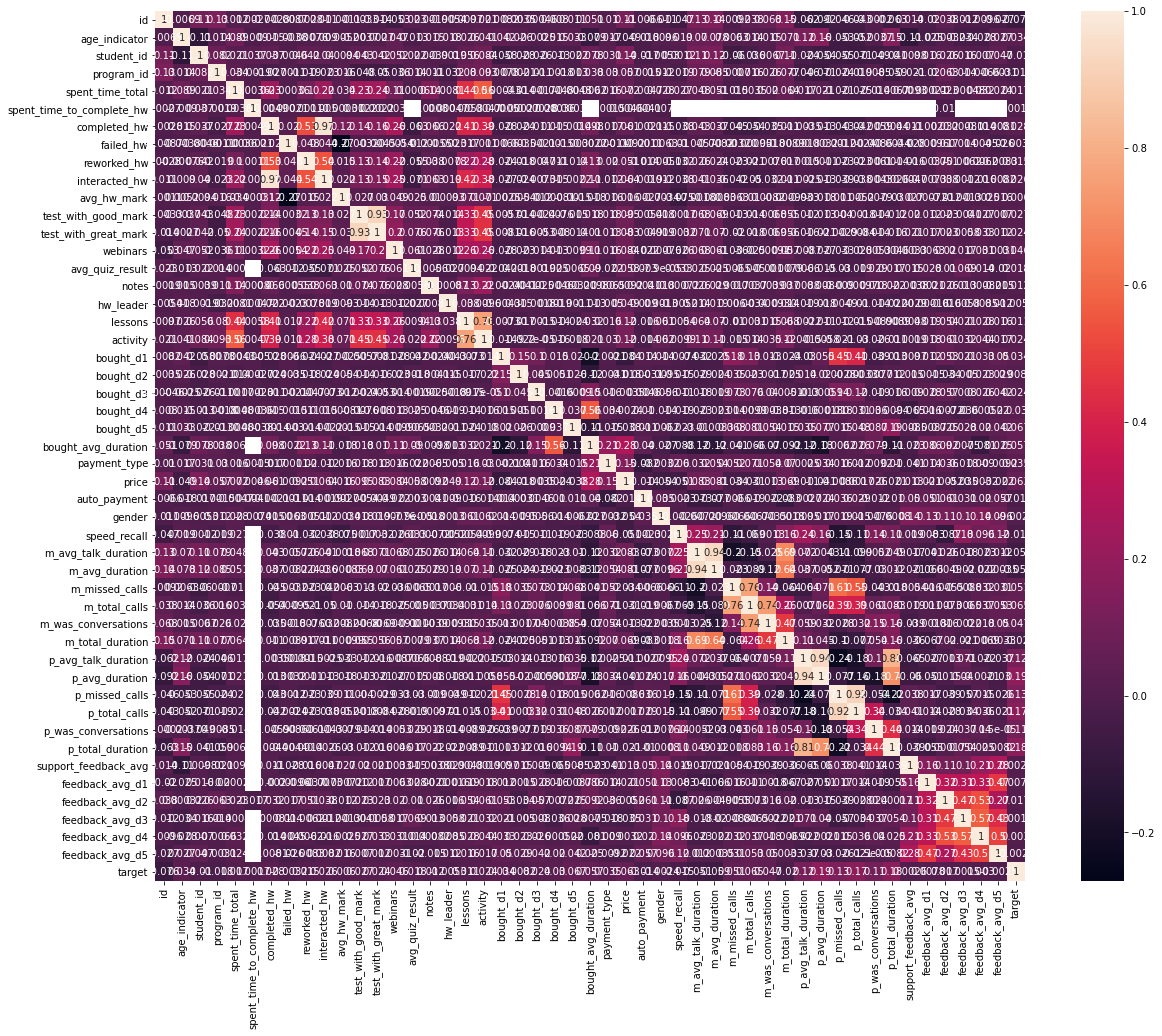

In [14]:
plt.figure(figsize = (20, 16))
sns.heatmap(train.corr(), square = True, annot=True)

In [31]:
train.columns

Index(['id', 'age_indicator', 'month_id', 'student_id', 'program_id',
       'carts_created_at', 'spent_time_total', 'spent_time_to_complete_hw',
       'completed_hw', 'failed_hw', 'reworked_hw', 'interacted_hw',
       'avg_hw_mark', 'test_with_good_mark', 'test_with_great_mark',
       'webinars', 'avg_quiz_result', 'notes', 'hw_leader', 'lessons',
       'activity', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 'bought_avg_duration', 'payment_type', 'promo', 'price',
       'communication_type', 'auto_payment', 'ABC', 'city', 'country',
       'gender', 'speed_recall', 'os', 'browser', 'platform',
       'm_avg_talk_duration', 'm_avg_duration', 'm_missed_calls',
       'm_total_calls', 'm_was_conversations', 'm_total_duration',
       'p_avg_talk_duration', 'p_avg_duration', 'p_missed_calls',
       'p_total_calls', 'p_was_conversations', 'p_total_duration',
       'support_feedback_avg', 'feedback_avg_d1', 'feedback_avg_d2',
       'feedback_avg_d3', 'fee

##  Обработка пустых значений, преобразование датасетов (train, test)

In [3]:
# список полей, в которых NaN будут заменены на 0
columns = ['spent_time_total', 'spent_time_to_complete_hw',
       'completed_hw', 'failed_hw', 'reworked_hw', 'interacted_hw',
       'avg_hw_mark', 'test_with_good_mark', 'test_with_great_mark',
       'webinars', 'avg_quiz_result', 'notes', 'hw_leader', 'lessons',
       'activity', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4',
       'bought_d5', 'bought_avg_duration', 'communication_type', 'speed_recall', 
       'm_avg_talk_duration', 'm_avg_duration', 'm_missed_calls',
       'm_total_calls', 'm_was_conversations', 'm_total_duration',
       'p_avg_talk_duration', 'p_avg_duration', 'p_missed_calls',
       'p_total_calls', 'p_was_conversations', 'p_total_duration',
       'support_feedback_avg', 'feedback_avg_d1', 'feedback_avg_d2',
       'feedback_avg_d3', 'feedback_avg_d4', 'feedback_avg_d5']

# Обработка пустых значений
train['age_indicator'] = train['age_indicator'].fillna(train['age_indicator'].median())
train['promo'] = train['promo'].map({'+': 1, '-': 0})
train['price'] = train['price'].fillna(train['price'].median())
train['communication_type'] = train['communication_type'].fillna('order')
train[columns] = train[columns].fillna(0)
train['gender'] = train['gender'].fillna(1)
#train['gender'] = train['gender'].map({0: np.random.uniform(1, 2)})
train['country'] = train['country'].fillna('Россия')
train['city'] = train['city'].fillna('Москва')
train['os'] = train['os'].fillna('Windows')
train['browser'] = train['browser'].fillna('Chrome')
train['platform'] = train['platform'].fillna('pc')

# результат, первые 5 строк
train.head(5)

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,avg_hw_mark,test_with_good_mark,test_with_great_mark,webinars,avg_quiz_result,notes,hw_leader,lessons,activity,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,bought_avg_duration,payment_type,promo,price,communication_type,auto_payment,ABC,city,country,gender,speed_recall,os,browser,platform,m_avg_talk_duration,m_avg_duration,m_missed_calls,m_total_calls,m_was_conversations,m_total_duration,p_avg_talk_duration,p_avg_duration,p_missed_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
0,15182,32.0,9/30/2020,6694527,1469,8/26/2020,163.0,0.0,1.0,0.0,17.0,3.0,100.0,12.0,8.0,0.0,0.0,147.0,0.0,14.0,32.0,0,0,0,0,0,0.0,1,1,20043.0,phone,0,D,Москва,Россия,1.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0
1,89385,20.0,6/30/2021,6712877,1392,8/5/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,15057.3,order,1,A,Москва,Россия,0.0,1.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,47931,20.0,2/28/2021,6659444,376,6/20/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,1,23389.0,web,0,D,Москва,Россия,0.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,279085,1.0,11/30/2021,7151591,1160,4/14/2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,22260.6,order,1,B,Москва,Россия,1.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,7806,30.0,10/31/2020,6705666,952,7/19/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,7255.5,order,1,A,Москва,Россия,1.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0


In [4]:
# Обработка пустых значений
test['age_indicator'] = test['age_indicator'].fillna(test['age_indicator'].median())
test['promo'] = test['promo'].map({'+': 1, '-': 0})
test['price'] = test['price'].fillna(test['price'].median())
test['communication_type'] = test['communication_type'].fillna('order')
test[columns] = test[columns].fillna(0)
test['gender'] = test['gender'].fillna(1)
test['country'] = test['country'].fillna('Россия')
test['city'] = test['city'].fillna('Москва')
test['os'] = test['os'].fillna('Windows')
test['browser'] = test['browser'].fillna('Chrome')
test['platform'] = test['platform'].fillna('pc')

# результат, первые 5 строк
test.head(5)

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,avg_hw_mark,test_with_good_mark,test_with_great_mark,webinars,avg_quiz_result,notes,hw_leader,lessons,activity,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,bought_avg_duration,payment_type,promo,price,communication_type,auto_payment,ABC,city,country,gender,speed_recall,os,browser,platform,m_avg_talk_duration,m_avg_duration,m_missed_calls,m_total_calls,m_was_conversations,m_total_duration,p_avg_talk_duration,p_avg_duration,p_missed_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5
0,77551,20.0,5/31/2021,7064806,1395,2/28/2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,22186.2,order,1,B,Москва,Россия,0.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,227812,27.0,5/31/2021,6982061,245,1/1/2021,81.0,0.0,5.0,0.0,13.0,7.0,100.0,4.0,0.0,6.0,0.0,0.0,0.0,24.0,32.0,0,0,0,0,0,0.0,1,0,64862.3,web,0,D,Москва,Россия,1.0,0.0,Windows,Chrome,pc,50.7,50.7,0.0,3.0,3.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,103035,9.0,6/30/2021,7118790,1233,3/19/2021,49.0,0.0,2.0,0.0,0.0,4.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,16.0,0,0,0,0,0,0.0,1,1,41637.6,order,1,D,Москва,Россия,1.0,0.0,iOS,Instagram,mobile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
3,260943,20.0,9/30/2021,7288419,784,6/29/2021,10.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,2.0,0,0,0,0,0,0.0,1,0,11677.8,order,0,C,Москва,Россия,0.0,0.0,iOS,Facebook,mobile,153.0,153.0,0.0,3.0,3.0,459.0,30.5,30.5,0.0,2.0,2.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0
4,134611,7.0,8/31/2021,6949976,998,12/31/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,7886.0,order,1,A,Москва,Россия,0.0,0.0,Android,Chrome Mobile,mobile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
test.isna().sum()

id                           0
age_indicator                0
month_id                     0
student_id                   0
program_id                   0
carts_created_at             0
spent_time_total             0
spent_time_to_complete_hw    0
completed_hw                 0
failed_hw                    0
reworked_hw                  0
interacted_hw                0
avg_hw_mark                  0
test_with_good_mark          0
test_with_great_mark         0
webinars                     0
avg_quiz_result              0
notes                        0
hw_leader                    0
lessons                      0
activity                     0
bought_d1                    0
bought_d2                    0
bought_d3                    0
bought_d4                    0
bought_d5                    0
bought_avg_duration          0
payment_type                 0
promo                        0
price                        0
communication_type           0
auto_payment                 0
ABC     

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 59 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         200000 non-null  int64  
 1   age_indicator              200000 non-null  float64
 2   month_id                   200000 non-null  object 
 3   student_id                 200000 non-null  int64  
 4   program_id                 200000 non-null  int64  
 5   carts_created_at           200000 non-null  object 
 6   spent_time_total           200000 non-null  float64
 7   spent_time_to_complete_hw  200000 non-null  float64
 8   completed_hw               200000 non-null  float64
 9   failed_hw                  200000 non-null  float64
 10  reworked_hw                200000 non-null  float64
 11  interacted_hw              200000 non-null  float64
 12  avg_hw_mark                200000 non-null  float64
 13  test_with_good_mark        20

Пустые значения заполнены, остались некоторые поля в формате строки. В дальнейшем можно данные поля преобразовать в числа, либо убрать из датасета.

<AxesSubplot:>

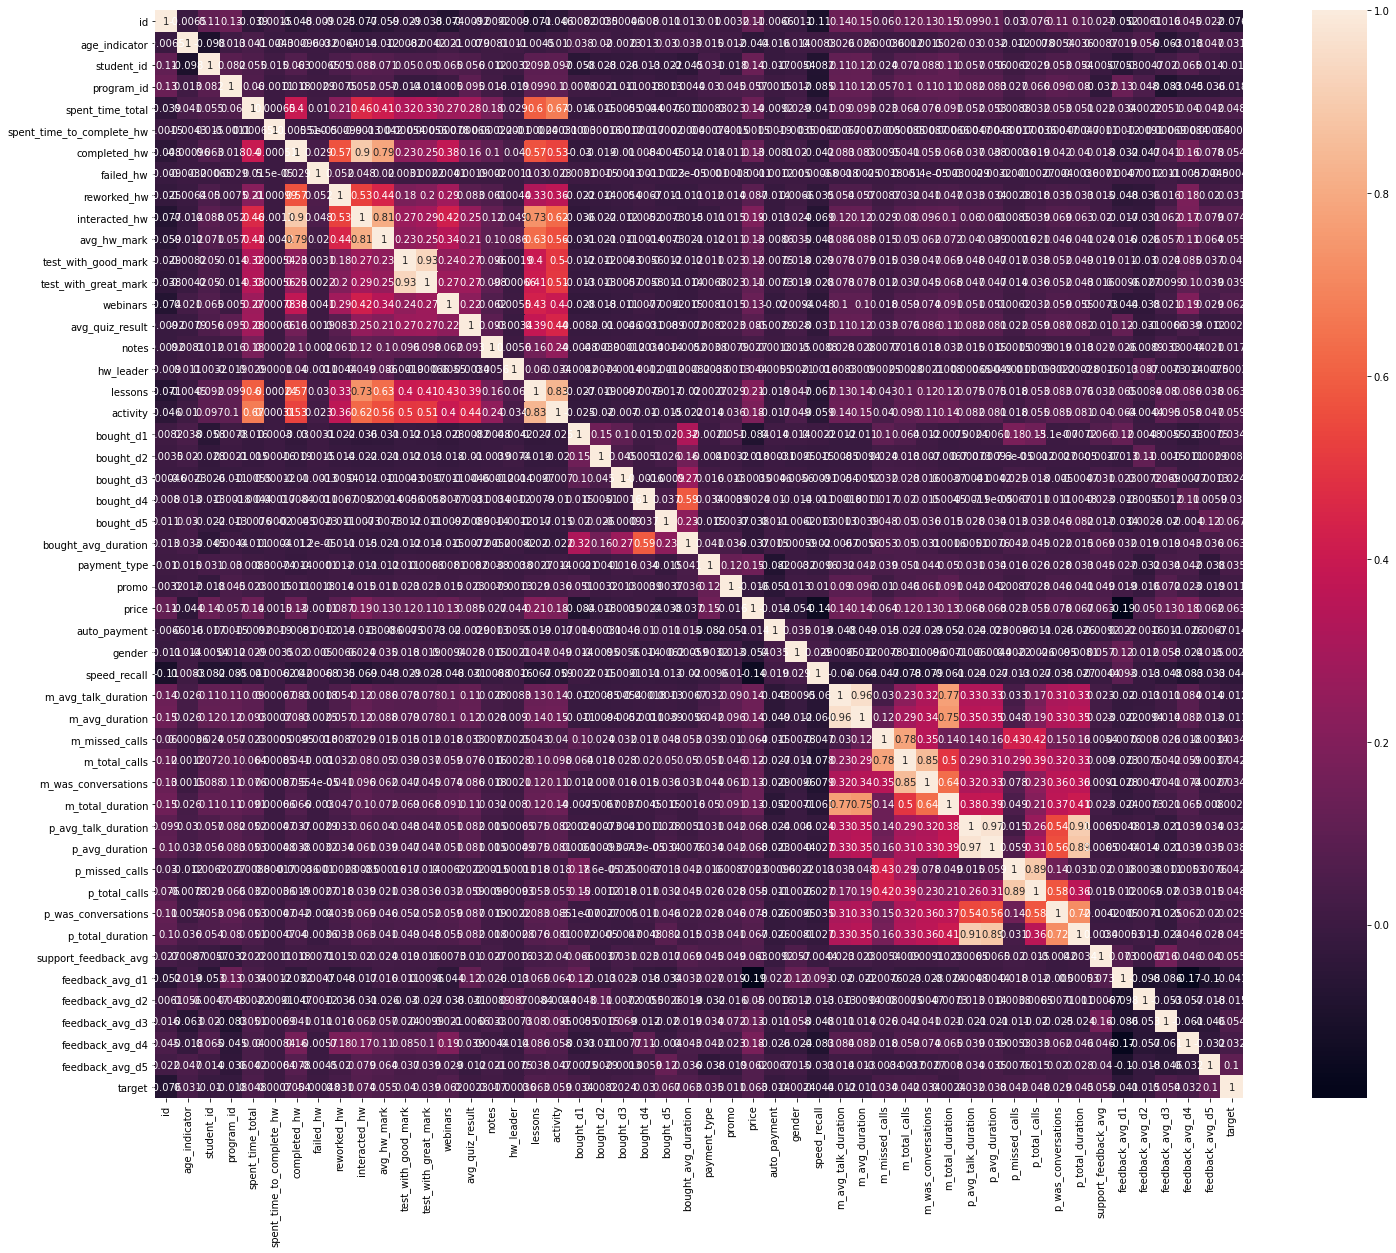

In [85]:
plt.figure(figsize = (25, 20))
sns.heatmap(train.corr(), square = True, annot=True)

После преобразования данных тепловая карта стала более читаемой. Можно отметить, что в предоставленном наборе данных есть три категории данных, которые описывают прогресс обучения, опыт повторных покупок и покупки после подачи заявки на сайте, а также опыт взаимодействия с телемаркетингом компании.

# Обучение модели 

In [5]:
# копирование датасета для дальнейшего распределения
data = train.drop(['month_id', 'carts_created_at'], axis=1).copy()
data.head()

,id,age_indicator,student_id,program_id,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,avg_hw_mark,test_with_good_mark,test_with_great_mark,webinars,avg_quiz_result,notes,hw_leader,lessons,activity,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,bought_avg_duration,payment_type,promo,price,communication_type,auto_payment,ABC,city,country,gender,speed_recall,os,browser,platform,m_avg_talk_duration,m_avg_duration,m_missed_calls,m_total_calls,m_was_conversations,m_total_duration,p_avg_talk_duration,p_avg_duration,p_missed_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
0,15182,32.0,6694527,1469,163.0,0.0,1.0,0.0,17.0,3.0,100.0,12.0,8.0,0.0,0.0,147.0,0.0,14.0,32.0,0,0,0,0,0,0.0,1,1,20043.0,phone,0,D,Москва,Россия,1.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0
1,89385,20.0,6712877,1392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,15057.3,order,1,A,Москва,Россия,0.0,1.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,47931,20.0,6659444,376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,1,23389.0,web,0,D,Москва,Россия,0.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,279085,1.0,7151591,1160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,22260.6,order,1,B,Москва,Россия,1.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,7806,30.0,6705666,952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,1,0,7255.5,order,1,A,Москва,Россия,1.0,0.0,Windows,Chrome,pc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0


In [6]:
# список категорий
cat_features = ['communication_type', 'ABC', 'city', 'country', 'os', 'browser', 'platform']

# переменные для нарезки на обучающие и тестовые данные
x = data.drop('target', axis=1)
y = data['target']


x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [7]:
# инициация модели
cb = CatBoostClassifier(iterations=1000,
                           depth=12,
                           #learning_rate=0.05,
                           loss_function='MultiClass',
                           cat_features=cat_features,
                           eta=0.2,
                           auto_class_weights='SqrtBalanced',
                           verbose=100,
                           use_best_model=True,
                           custom_metric=['MultiClass',
                                          'AUC:hints=skip_train~false', 'F1']).fit(X=x_train, 
                                                                                    y=y_train,
                                                                                    cat_features=cat_features,
                                                                                    eval_set=(x_test, y_test),
                                                                                    verbose=100,
                                                                                    use_best_model=True,
                                                                                    plot=True)

# получение предсказанных результатов
cb_predict_train = cb.predict(x_train)
cb_predict = cb.predict(x_test)

# результаты
preds_class = cb.predict(x_test)
#preds_proba = cb.predict_proba(x_te)
print("class = ", preds_class)
#print("proba = ", preds_proba)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5098637	test: 1.5175971	best: 1.5175971 (0)	total: 11.4s	remaining: 3h 9m 42s
100:	learn: 0.3859179	test: 0.6219046	best: 0.6219046 (100)	total: 15m 42s	remaining: 2h 19m 44s
200:	learn: 0.1948953	test: 0.5042980	best: 0.5042977 (199)	total: 31m 33s	remaining: 2h 5m 27s
300:	learn: 0.1287925	test: 0.4743408	best: 0.4742136 (299)	total: 48m 29s	remaining: 1h 52m 36s
400:	learn: 0.0938741	test: 0.4640879	best: 0.4640879 (400)	total: 1h 5m 10s	remaining: 1h 37m 21s
500:	learn: 0.0738522	test: 0.4634492	best: 0.4632246 (498)	total: 1h 22m 8s	remaining: 1h 21m 48s
600:	learn: 0.0602123	test: 0.4635621	best: 0.4626253 (549)	total: 1h 39m 39s	remaining: 1h 6m 9s
700:	learn: 0.0497973	test: 0.4628271	best: 0.4618932 (659)	total: 1h 57m 25s	remaining: 50m 5s
800:	learn: 0.0423649	test: 0.4658385	best: 0.4618932 (659)	total: 2h 15m 5s	remaining: 33m 33s
900:	learn: 0.0360290	test: 0.4686486	best: 0.4618932 (659)	total: 2h 33m 13s	remaining: 16m 50s
999:	learn: 0.0318757	test: 0.47196

In [8]:
# проверка обучена ли модель
cb.is_fitted()

True

In [60]:
# сохранение модели
cb.save_model('catboostclassifier', format="cbm")

In [9]:
print('Скор на тренировочной выборке:', cb.score(x_train, y_train),
      'Скор на тестовой выборке:', cb.score(x_test, y_test))

Скор на тренировочной выборке: 0.9955928571428572 Скор на тестовой выборке: 0.9427


# Оценка точности

В качестве метрики выступает взвешенная сумма Recall и Precision по
следующей формуле:
<br><br>
𝑅𝑒𝑠𝑢𝑙𝑡 = 0. 2 * 𝑅𝑒𝑐𝑎𝑙𝑙 + 0. 8 * 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜n

In [10]:
recall = recall_score(y_test, cb_predict, average='weighted')

precision = precision_score(y_test, cb_predict, average='weighted')

result = 0.2 * recall + 0.8 * precision

print('Result =', result)

Result = 0.9404657028780958


# Подготовка файла для проверки

In [11]:
# убираем колонки с датами
test.drop(['month_id', 'carts_created_at'], axis=1, inplace=True)

In [12]:
# предсказание модели на тестовых данных
test_predict = cb.predict(test)
test_predict

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

Для сдачи работы на проверку потребуется собрать таблицу, в которой содержатся id и предсказания target. Следующим шагом будет создание csv файла для загрузки на платформу.

In [13]:
# отбор id 
result_data = pd.DataFrame(test['id'])

# отбор предсказанных классов
result_predict = pd.DataFrame(test_predict, columns=['target'])

# объединение данных
data_check = result_data.merge(right=result_predict, how='inner', 
                                on=None, 
                                left_on=None, 
                                right_on=None, 
                                left_index=True, 
                                right_index=True, 
                                sort=False, 
                                #suffixes=('_x', '_y'), 
                                copy=True, 
                                indicator=False, 
                                validate=None)

# перевод target в формат строки, т.к. бывает, что нули (т.е. нулевой класс в нашем случае) удаляются при экспорте в csv
data_check['target'] = data_check['target'].astype('str')

data_check

,id,target
0,77551,0
1,227812,0
2,103035,0
3,260943,0
4,134611,0
...,...,...
84992,186427,0
84993,197918,0
84994,174961,0
84995,182226,0


In [78]:
# проверка переформатирования строки
data_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84997 entries, 0 to 84996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      84997 non-null  int64 
 1   target  84997 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [14]:
# экспорт данных в csv
data_check.to_csv('sample_solution_eta02_str.csv', index=False, encoding='utf-8')